# <center> Machine learning process for electricity load forecasting <center>

## 1. Data Preparation
Prepare the data for time series forecasting, including feature engineering and splitting into train/test sets.

## Steps:

#### Load and Preprocess Data:

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the cleaned data
df = pd.read_csv('/Users/bkh42/Downloads/cleaned_household_energy_consumption.csv')

# Convert datetime column back to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Set datetime as index for time series analysis
df.set_index('datetime', inplace=True)
df = df.asfreq('T')
# Select the target variable for forecasting
target = 'Global_active_power'

#### Feature Engineering:

In [11]:
# Create lag features (e.g., previous day's values)
df['lag_1_day'] = df[target].shift(24*60)  # 24 hours * 60 minutes
df['lag_7_days'] = df[target].shift(7*24*60)  # 7 days * 24 hours * 60 minutes

# Create rolling statistics
df['rolling_mean_24h'] = df[target].rolling(window=24*60).mean()
df['rolling_std_24h'] = df[target].rolling(window=24*60).std()

# Drop NaN values created by lag and rolling features
df.dropna(inplace=True)

#### Splitting Data:

In [19]:
# Split the data into train and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# Identify numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Scale only the numeric features
scaler_features = MinMaxScaler()
train[numeric_columns] = scaler_features.fit_transform(train[numeric_columns])
test[numeric_columns] = scaler_features.transform(test[numeric_columns])

# Create a separate scaler for the target variable
scaler_target = MinMaxScaler()
train_target_scaled = scaler_target.fit_transform(train[target].values.reshape(-1, 1))
test_target_scaled = scaler_target.transform(test[target].values.reshape(-1, 1))

## 2. Model Selection
Choose an appropriate model for time series forecasting.



In [20]:
from statsmodels.tsa.arima.model import ARIMA
# We'll use ARIMA as an example
model = ARIMA(train[target], order=(5, 1, 0))  # You may need to tune these parameters

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 3. Model Training
Purpose: Train the selected model on the training data.

In [21]:
# Fit the model
results = model.fit()

## 4. Model Evaluation

#### Make Predictions on Test Set:


In [24]:
# Forecast on test set
forecast_scaled = results.forecast(steps=len(test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#### Calculate Evaluation Metrics:

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Forecast on test set
forecast_scaled = results.forecast(steps=len(test))

# Inverse transform the predictions and actual values using the target scaler
# Convert forecast Series to numpy array before reshaping
forecast_inv = scaler_target.inverse_transform(forecast_scaled.values.reshape(-1, 1)).flatten()
actual_inv = scaler_target.inverse_transform(test_target_scaled).flatten()

# Calculate MAE and RMSE
mae = mean_absolute_error(actual_inv, forecast_inv)
rmse = np.sqrt(mean_squared_error(actual_inv, forecast_inv))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean Absolute Error (MAE): 0.0882120584669211
Root Mean Squared Error (RMSE): 0.10257742695974445


#### Visualize the Results:

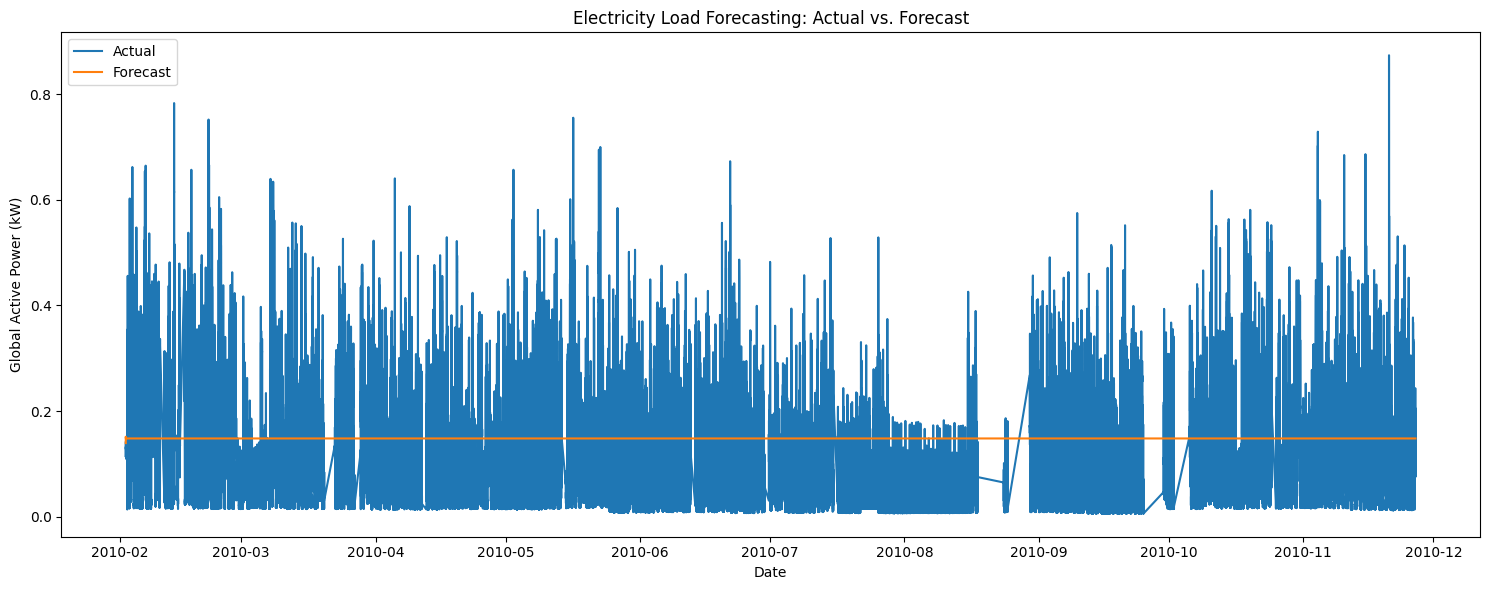

In [27]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted
plt.figure(figsize=(15, 6))
plt.plot(test.index, actual_inv, label='Actual')
plt.plot(test.index, forecast_inv, label='Forecast')
plt.title('Electricity Load Forecasting: Actual vs. Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Forecasting

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


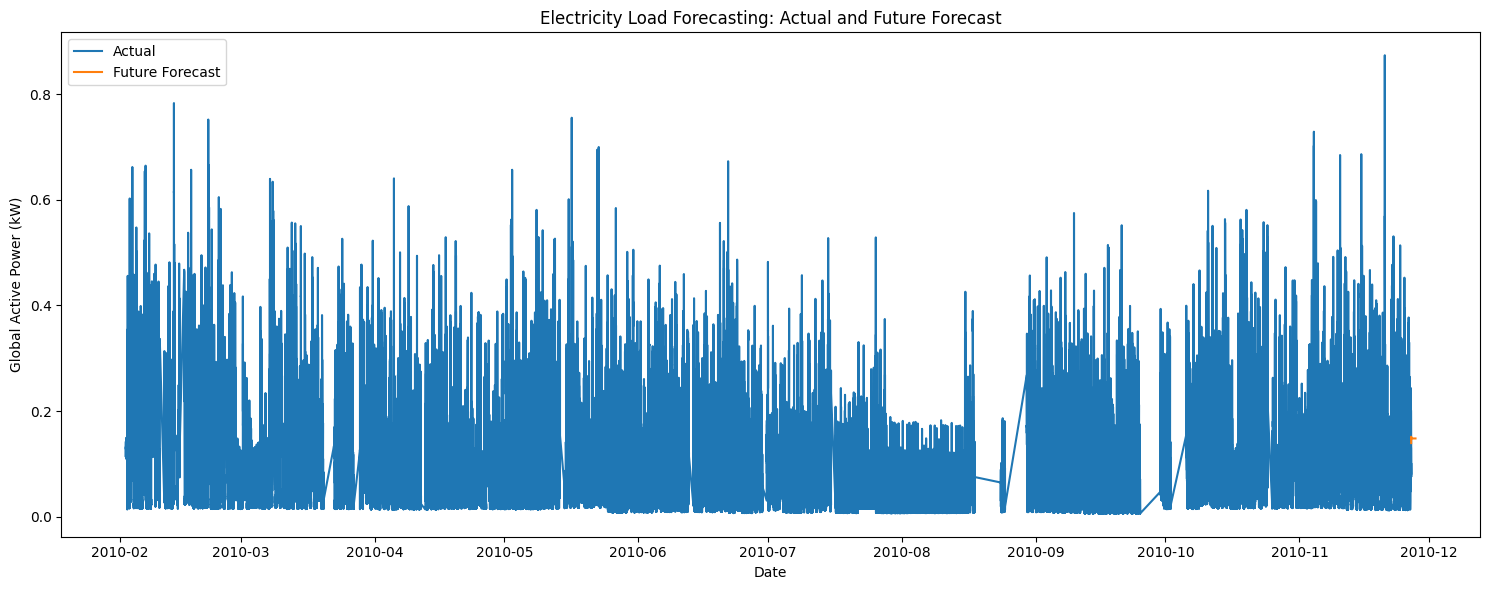

In [30]:
# Forecast future values (e.g., for next 24 hours)
future_steps = 24 * 60  # 24 hours * 60 minutes
future_forecast_scaled = results.forecast(steps=future_steps)

# Inverse transform the future forecast
# Convert forecast Series to numpy array before reshaping
future_forecast_inv = scaler_target.inverse_transform(future_forecast_scaled.values.reshape(-1, 1)).flatten()

# Create future datetime index
future_index = pd.date_range(start=test.index[-1], periods=future_steps+1, freq='T')[1:]

# Create a DataFrame with future forecast
future_df = pd.DataFrame({'datetime': future_index, 'forecast': future_forecast_inv})
future_df.set_index('datetime', inplace=True)

# Plot future forecast
plt.figure(figsize=(15, 6))
plt.plot(test.index, actual_inv, label='Actual')
plt.plot(future_df.index, future_df['forecast'], label='Future Forecast')
plt.title('Electricity Load Forecasting: Actual and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Choose the model (example parameters, you may need to tune these)
model = SARIMAX(train_target_scaled, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24*60))  # 24*60 for daily seasonality in minute data

# Train the model
results = model.fit()

# Forecast on test set
forecast_scaled = results.forecast(steps=len(test))

# Inverse transform the predictions and actual values using the target scaler
forecast_inv = scaler_target.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
actual_inv = scaler_target.inverse_transform(test_target_scaled).flatten()

# Plot actual vs. predicted
plt.figure(figsize=(15, 6))
plt.plot(test.index, actual_inv, label='Actual')
plt.plot(test.index, forecast_inv, label='Forecast')
plt.title('Electricity Load Forecasting: Actual vs. Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()